# Автоматическое машинное обучение с помощью AutoKeras:

In [0]:
!pip install --upgrade autokeras

In [0]:
import pandas as pd
import numpy as np
import autokeras as ak

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

prefix = "drive/My Drive/automl/data/"
SEED = 42

In [0]:
train = pd.read_csv(prefix + "categorical_less_train.csv")

In [0]:
# Удалим OHE-признаки, т.к. их намного больше, чем основных
col_for_drop = []
for col in train.columns:
    if col.find('product_category_name') != -1:
        col_for_drop.append(col)
train.drop(col_for_drop, axis=1, inplace=True)

In [0]:
# Нормализуем столбцы со временем порядка 10^9
big_time = ['shipping_limit_date_seconds', 'review_creation_date_seconds', 'review_answer_timestamp_seconds']

In [0]:
from sklearn.preprocessing import StandardScaler

for data_column in big_time:
    train[data_column] = StandardScaler().fit_transform(train[data_column].values.reshape((-1, 1)))

In [43]:
# Удалим Nan-значения
print("Размер выборки до удаления:", train.shape)
train = train.dropna()
print("Размер выборки после удаления:", train.shape)

Размер выборки до удаления: (51253, 22)
Размер выборки после удаления: (51247, 22)


# Прежде чем запускать поиск моделей, выделим топ-15 наиболее скоррелированных с целевой переменной признаков:

In [0]:
structured_train = train.copy()

for col in train.columns:
    # удалим id's
    tps = np.vectorize(lambda x: type(x) == str)(structured_train[col].values).sum()
    if col[-2:] == 'id' or tps > 0:
        structured_train.drop([col], axis=1, inplace=True)

In [0]:
X, y = structured_train.drop(['price'], axis=1), structured_train['price']

Выбираем признаки на основе F-статистики:

In [12]:
# Воспользуемся методом из sklearn
from sklearn.feature_selection import SelectKBest, f_regression

best_features_model = SelectKBest(score_func=f_regression, k=10)
fit = best_features_model.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Выполним визуализацию полученных признаков
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
# Выведем топ-15 признаков
print(featureScores.nlargest(15, 'Score'))

                                    Specs         Score
9                           payment_value  44844.723901
5                           freight_value  11017.727650
14                       product_weight_g   6951.526042
8                    payment_installments   4105.295888
16                      product_height_cm   2836.507208
12             product_description_lenght   2122.059733
17                       product_width_cm   1606.420777
15                      product_length_cm   1361.506336
13                     product_photos_qty    179.235860
2    order_delivered_carrier_date_seconds     50.010225
3   order_delivered_customer_date_seconds     48.384547
7                      payment_sequential     29.865490
11                    product_name_lenght      4.493186
0        order_purchase_timestamp_seconds      2.825267
6             shipping_limit_date_seconds      2.054534


In [0]:
# Рассмотрим топ-8 признаков на основе полученных данных, т.к. они сильно выделяются по сравнению с остальными
top_features = ['payment_value', 'freight_value', 'product_weight_g', 'payment_installments',
                'product_height_cm', 'product_description_lenght', 'product_length_cm', 'product_width_cm', 'price']

In [0]:
structured_train = structured_train[top_features]

# Рассматриваем две модели:

1. `StructuredDataRegressor` -- для оценивания табличных данных. Качество будет сравниваться с бейзлайном -- `CatBoost`.
2. `TextRegressor` -- для оценивания текстовых данных. Качество будет сравниваться с бейзлайном -- `Bidirectional LSTM`.

## StructuredDataRegressor:

In [0]:
X, y = structured_train.drop(['price'], axis=1), structured_train['price']

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, train_size=0.7)

In [0]:
structured_train = X_train.copy()
structured_eval = X_eval.copy()

structured_train['price'], structured_eval['price'] = np.nan, np.nan

structured_train['price'] = y_train.values
structured_eval['price'] = y_eval.values

In [0]:
structured_train.to_csv(prefix + "structured_train.csv", index=False)
structured_eval.to_csv(prefix + "structured_eval.csv", index=False)

Попробуем оптимизировать разные функции потерь:

1.   Mean squared error;
2.   Mean absolute error;
3.   Mean squared logarithmic error;



In [0]:
losses = ['mean_squared_error', 'mean_squared_logarithmic_error', 'mean_absolute_error']

In [0]:
regressor = ak.StructuredDataRegressor(max_trials=20, loss=losses[1])
regressor.fit(x=prefix + "structured_train.csv", y='price', epochs=100, validation_split=0.2)

In [29]:
print('Функция потерь на трейне/тесте: {losses}'.format(
    losses=regressor.evaluate(x=prefix + 'structured_eval.csv', y='price')))

481/481 [==============================] - 1s 2ms/step - loss: 19.9437 - mean_squared_error: 67901.4609
Функция потерь на трейне/тесте: [19.943662643432617, 67901.4609375]


In [0]:
y_pred = regressor.predict(X_eval.values)

In [0]:
rmse =  np.sqrt(mean_squared_error(y_eval, y_pred))
mae = mean_absolute_error(y_eval, y_pred)
r_squared = r2_score(y_eval, y_pred)

In [32]:
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2;", r_squared)

RMSE: 260.57908245869646
MAE: 158.2340086391017
R^2; -0.6578374839701511


### Результаты по оптимизации 3-х метрик:

Были заданы параметры `max_trials=20` и `epochs=100`.

1.   `mean_absolute_error`: $R^2 = 0.5859$
2.   `mean_squared_logarithmic_error`: $R^2 = -0.65$
3.   `mean_squared_error`: $R^2 = 0.6588$

Таким образом, лучше всего оптимизировать MSE.

### Изобразим полученную модель:

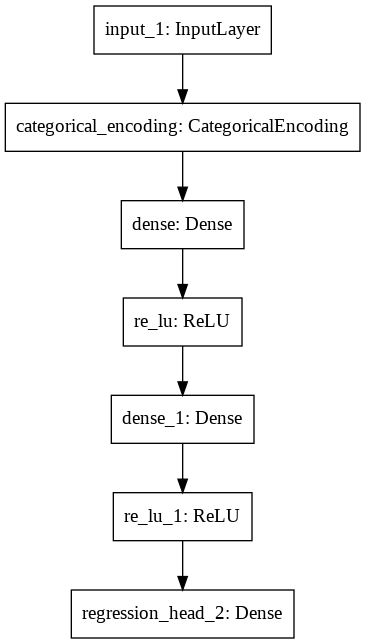

In [149]:
from tensorflow.keras.layers import Layer

model = regressor.export_model()

model._layers = [layer for layer in model._layers if not isinstance(layer, dict)]

tf.keras.utils.plot_model(model)

## TextRegressor:

#### Предобработаем данные в `np.ndarray`:
Из текстовых данных мы рассматриваем только `review_comment_message` и `product_category_name`.

In [0]:
# Заново загрузим и предобработаем train для добавления текстового столбца
train = pd.read_csv(prefix + "train.csv")

In [0]:
train = train[['price', 'review_comment_message', 'product_category_name']]

In [7]:
# Удалим Nan-значения
print("Размер выборки до удаления:", train.shape)
train = train.dropna()
print("Размер выборки после удаления:", train.shape)

Размер выборки до удаления: (51253, 3)
Размер выборки после удаления: (49893, 3)


In [8]:
train.head()

,price,review_comment_message,product_category_name
0,29.99,"Não testei o produto ainda, mas ele veio corre...",utilidades_domesticas
1,29.99,"Não testei o produto ainda, mas ele veio corre...",utilidades_domesticas
2,29.99,"Não testei o produto ainda, mas ele veio corre...",utilidades_domesticas
3,118.7,Muito bom o produto.,perfumaria
4,45,O produto foi exatamente o que eu esperava e e...,pet_shop


In [9]:
# Удалим строчки с плохим значением price
print('Размер выборки до удаления:', train.shape)
train = train[np.vectorize(type)(train['price'].values) == float]
print('Размер выборки после удаления:', train.shape)

Размер выборки до удаления: (49893, 3)
Размер выборки после удаления: (49390, 3)


In [0]:
text_data = train.copy()

X, y = text_data.drop(['price'], axis=1), text_data['price'].values
y = np.vectorize(float)(y)

In [0]:
# Остается понять, как два текстовых признака объединить в один. Стэкинг не должен восприниматься моделью корректно
# И поэтому оставим только review_comment_message

X = X['review_comment_message'].to_numpy(dtype='str')

X_train, X_eval, y_train, y_eval = train_test_split(X, y, train_size=0.70, random_state=SEED)

Есть два случая в зависимости от размера словаря:

1. Если словарь маленький, можно использовать `TextRegressor` напрямую.
2. Если размер велик, можно сделать токенизацию руками и вызвать `AutoModel`.

### (1). Небольшой размер словаря:

In [12]:
reg = ak.TextRegressor(max_trials=5) 

reg.fit(X_train, y_train, epochs=5)

Epoch 1/5
865/865 [==============================] - 46s 53ms/step - loss: 38103.3203 - mean_squared_error: 38103.3203 - val_loss: 51385.3203 - val_mean_squared_error: 51385.3203
Epoch 2/5
865/865 [==============================] - 45s 52ms/step - loss: 36318.6758 - mean_squared_error: 36318.6758 - val_loss: 51498.4609 - val_mean_squared_error: 51498.4609
Epoch 3/5
865/865 [==============================] - 44s 51ms/step - loss: 33972.7773 - mean_squared_error: 33972.7773 - val_loss: 52525.0781 - val_mean_squared_error: 52525.0781
Epoch 4/5
865/865 [==============================] - 45s 52ms/step - loss: 31271.3848 - mean_squared_error: 31271.3848 - val_loss: 53868.3164 - val_mean_squared_error: 53868.3164
Epoch 5/5
865/865 [==============================] - 45s 52ms/step - loss: 28571.5879 - mean_squared_error: 28571.5879 - val_loss: 55258.7500 - val_mean_squared_error: 55258.7500


Epoch 1/5
865/865 [==============================] - 122s 141ms/step - loss: 38246.4023 - mean_squared_error: 38246.4023 - val_loss: 50856.7305 - val_mean_squared_error: 50856.7305
Epoch 2/5
865/865 [==============================] - 119s 137ms/step - loss: 30002.4570 - mean_squared_error: 30002.4570 - val_loss: 51098.3594 - val_mean_squared_error: 51098.3594
Epoch 3/5
865/865 [==============================] - 119s 137ms/step - loss: 24501.9785 - mean_squared_error: 24501.9785 - val_loss: 52043.5859 - val_mean_squared_error: 52043.5859
Epoch 4/5
865/865 [==============================] - 119s 137ms/step - loss: 22072.3711 - mean_squared_error: 22072.3711 - val_loss: 52246.6562 - val_mean_squared_error: 52246.6562
Epoch 5/5
865/865 [==============================] - 118s 137ms/step - loss: 20605.8340 - mean_squared_error: 20605.8340 - val_loss: 52935.6797 - val_mean_squared_error: 52935.6797


Epoch 1/5
865/865 [==============================] - 69s 80ms/step - loss: 44148.7773 - mean_squared_error: 44148.7773 - val_loss: 51329.8750 - val_mean_squared_error: 51329.8750
Epoch 2/5
865/865 [==============================] - 71s 82ms/step - loss: 29301.8652 - mean_squared_error: 29301.8652 - val_loss: 51595.8672 - val_mean_squared_error: 51595.8672
Epoch 3/5
865/865 [==============================] - 70s 81ms/step - loss: 22548.5176 - mean_squared_error: 22548.5176 - val_loss: 52961.2617 - val_mean_squared_error: 52961.2617
Epoch 4/5
865/865 [==============================] - 69s 80ms/step - loss: 18000.6211 - mean_squared_error: 18000.6211 - val_loss: 53479.6328 - val_mean_squared_error: 53479.6328
Epoch 5/5
865/865 [==============================] - 69s 80ms/step - loss: 14705.8682 - mean_squared_error: 14705.8682 - val_loss: 53779.9258 - val_mean_squared_error: 53779.9258


Epoch 1/5
865/865 [==============================] - 20s 23ms/step - loss: 38314.6133 - mean_squared_error: 38314.6133 - val_loss: 50948.7891 - val_mean_squared_error: 50948.7891
Epoch 2/5
865/865 [==============================] - 20s 23ms/step - loss: 30743.8340 - mean_squared_error: 30743.8340 - val_loss: 51435.3164 - val_mean_squared_error: 51435.3164
Epoch 3/5
865/865 [==============================] - 20s 23ms/step - loss: 24272.6309 - mean_squared_error: 24272.6309 - val_loss: 52122.6836 - val_mean_squared_error: 52122.6836
Epoch 4/5
865/865 [==============================] - 20s 23ms/step - loss: 20516.2227 - mean_squared_error: 20516.2227 - val_loss: 52772.5039 - val_mean_squared_error: 52772.5039
Epoch 5/5
865/865 [==============================] - 20s 23ms/step - loss: 18709.7656 - mean_squared_error: 18709.7656 - val_loss: 52843.2578 - val_mean_squared_error: 52843.2578


Epoch 1/5
865/865 [==============================] - 68s 79ms/step - loss: 39614.1094 - mean_squared_error: 39614.1094 - val_loss: 51736.8945 - val_mean_squared_error: 51736.8945
Epoch 2/5
865/865 [==============================] - 68s 79ms/step - loss: 33355.8594 - mean_squared_error: 33355.8594 - val_loss: 51166.1172 - val_mean_squared_error: 51166.1172
Epoch 3/5
865/865 [==============================] - 68s 79ms/step - loss: 29172.4023 - mean_squared_error: 29172.4023 - val_loss: 51531.3125 - val_mean_squared_error: 51531.3125
Epoch 4/5
865/865 [==============================] - 70s 81ms/step - loss: 25755.1309 - mean_squared_error: 25755.1309 - val_loss: 52186.4492 - val_mean_squared_error: 52186.4492
Epoch 5/5
865/865 [==============================] - 68s 79ms/step - loss: 23071.9668 - mean_squared_error: 23071.9668 - val_loss: 52747.9336 - val_mean_squared_error: 52747.9336


INFO:tensorflow:Oracle triggered exit
Epoch 1/5
1082/1082 [==============================] - 147s 136ms/step - loss: 41748.7305 - mean_squared_error: 41748.7305 - val_loss: 43390.6719 - val_mean_squared_error: 43390.6719
Epoch 2/5
1082/1082 [==============================] - 146s 135ms/step - loss: 34355.0078 - mean_squared_error: 34355.0078 - val_loss: 32994.8477 - val_mean_squared_error: 32994.8477
Epoch 3/5
1082/1082 [==============================] - 146s 135ms/step - loss: 28794.4121 - mean_squared_error: 28794.4121 - val_loss: 25852.0840 - val_mean_squared_error: 25852.0840
Epoch 4/5
1082/1082 [==============================] - 147s 136ms/step - loss: 25080.9980 - mean_squared_error: 25080.9980 - val_loss: 21417.1719 - val_mean_squared_error: 21417.1719
Epoch 5/5
1082/1082 [==============================] - 146s 135ms/step - loss: 24355.3789 - mean_squared_error: 24355.3789 - val_loss: 19705.2988 - val_mean_squared_error: 19705.2988


In [0]:
y_pred = reg.predict(X_eval)

In [0]:
rmse =  np.sqrt(mean_squared_error(y_eval, y_pred))
mae = mean_absolute_error(y_eval, y_pred)
r_squared = r2_score(y_eval, y_pred)

In [16]:
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2;", r_squared)

RMSE: 182.90031079534026
MAE: 88.39198961056476
R^2; 0.015253284910314635


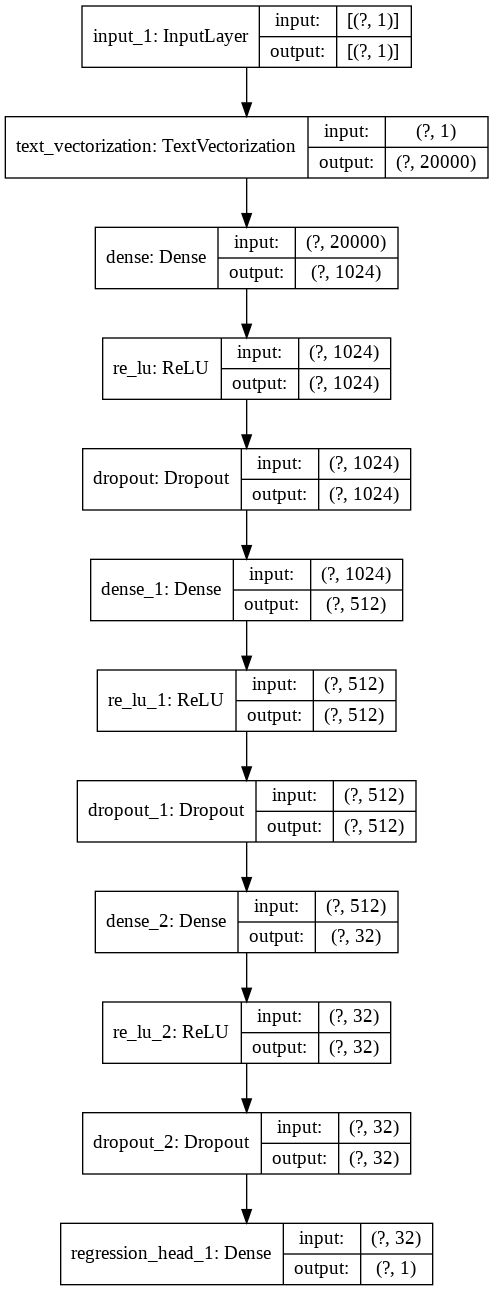

In [21]:
# Изобразим модель
import tensorflow as tf
from tensorflow.keras.layers import Layer

model = reg.export_model()

model._layers = [layer for layer in model._layers if not isinstance(layer, dict)]

tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

### (2). Большой размер словаря:

In [0]:
input_node = ak.TextInput()
output_node = ak.TextToIntSequence(max_tokens=20000)(input_node)

output_node = ak.RegressionHead()(output_node)

reg = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=15)
reg.fit(X_train, y_train)

In [0]:
y_pred = reg.predict(X_eval.values)

In [0]:
rmse =  np.sqrt(mean_squared_error(y_eval, y_pred))
mae = mean_absolute_error(y_eval, y_pred)
r_squared = r2_score(y_eval, y_pred)

In [0]:
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2;", r_squared)